## NN Fundamentales keras

Vamos a ver los fundamentos de las Redes Nueronales.

In [ ]:
# Importación de librerias
import tensorflow as tf # importación de la libreria de deep learning tensorflow
from tensorflow import keras # Importación de la API de alto nivel para definir, entrenar, evaluar y guardar modelos de deep learning
from tensorflow.keras import layers #es el submódulo de Keras que reúne todas las capas que usas para construir redes neuronales.Cada capa es un bloque que transforma tensores (entrada → salida) y puede tener pesos entrenables.

import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt

tf.random.set_seed(0)

In [ ]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    h = 0.05
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap=plt.cm.Spectral)

def load_planar_dataset(m, sigma=0.2):
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*sigma # theta
        r = a*np.sin(4*t) + np.random.randn(N)*sigma # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    ## premuting ouput
    p = np.random.permutation(m)
    X = X[p,:]
    Y = Y[p,:]

    return X, Y.ravel()

def draw_neural_net(left, right, bottom, top, layer_sizes):
    '''
    From https://gist.github.com/craffel/2d727968c3aaebd10359#file-draw_neural_net-py
    Draw a neural network cartoon using matplotilb.

    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])

    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    fig = plt.figure(figsize=(3, 3))
    ax = fig.gca()
    ax.axis('off')

    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

### Dataset

Tenemos un dataset con una clasificación binaria. El targey (y) tiene dos posibles valores (0,1) y el vector de input (X) tiene dos dimensiones

In [ ]:
N = 5000 # Definimos el mumero de muestras que queremos en nuestro dataset sintético
X, y = load_planar_dataset(N, 0.2) # Genera un dataset planar (2D) con 5.000 puntos y 0.2 de nivel de ruido (dispersión/solapamiento entre clases)

Visualizamos el dataset usando matplotlib. El dataset se ve como una flor con puntos rojos (label y=0) y con puntos azules (y=1). El objetivo es construir un modelo para entrenar esos datos.

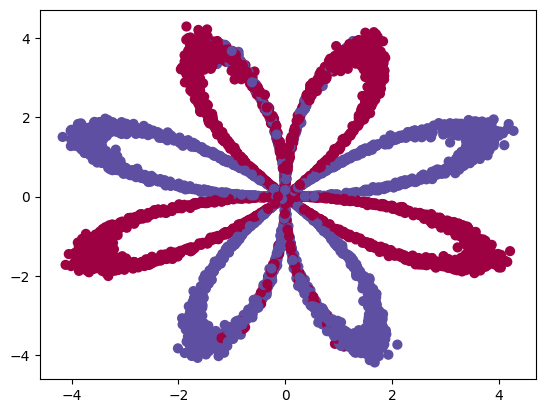

In [ ]:
# Visualización de los datos
plt.scatter(X[:,0],X[:,1], c=y.ravel(),s=40, cmap=plt.cm.Spectral);

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(X , y, test_size=0.2
)

In [ ]:
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(4000, 2), y_train shape:(4000,)
X_test shape:(1000, 2), y_test shape:(1000,)


In [ ]:
## X primer ejemplo
X[0,:]

array([-0.51680838,  0.57093347])

In [ ]:
## Y primer ejemplo
y[:8]

array([0, 0, 1, 1, 0, 0, 1, 1], dtype=uint8)

### Primera NN en Keras

Regresión Logistica:

Las capas totalmente conectadas se definen usando la clase Dense (Capas Densas: conexión de todas parámetros). Podemos especificar el número de neuronas como primer argumento y la función de activación mediante el argument `activation`.

```python
tf.keras.layers.Dense(
    units, activation=None
)
```

*   units: número de neuronas de la capa
*   activation: Función de activación a usar; por defecto es `linear` (lineal). también puede usar `sigmoid` para activación sigmoide (no lineal).  


Para definir la capa de entrada se puede usar `keras.Input(shape(input_dimension,))` o definir la dimension de entrada en la primera capa oculta.

``` python
layers.Dense(4, activation="sigmoid", input_shape=(input_dimension,))
```

Construye una red sin capa oculta.



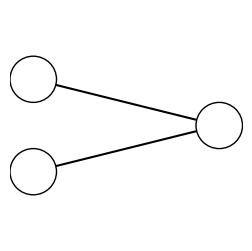

In [ ]:
draw_neural_net (.1,.9,.1,.9,[2,1])  # Simplemente ilustra el tipo de red

In [ ]:
model = keras.Sequential() # Creación de un modelo secuencial, es un contenedor para apilar capas en orden lineal (una detrás de otra)
# La dimensión del iout es 2 (datos planares)
# Solo tenemos un parámetro de ouput con 1 neurona
model.add(keras.layers.Dense(1, input_shape=(2,), activation='sigmoid'))

In [ ]:
model.summary() # muestra un resumen de la red en Keras

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

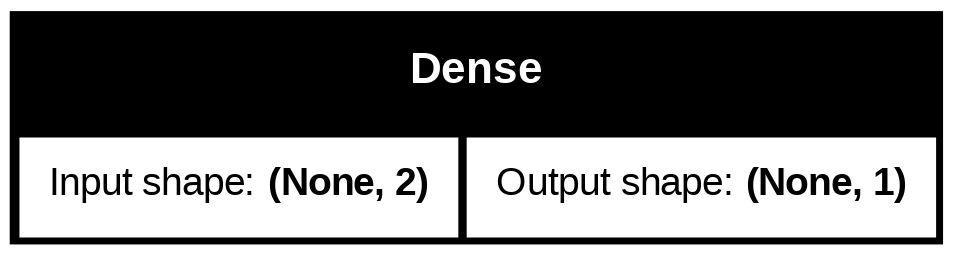

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

#### Compilación

Ahora necesitamos especificar la function de perdida (loss function), las metricas y el optimizador. Se hace mediante la función `compile()` en keras

In [ ]:
# Necesario para que quede listo para entrenar indicando como debe aprender y qué evaluar.
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = ['accuracy', 'precision']
)

#### Training model

Similar a sklearn model

In [ ]:
model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6714 - loss: 1.2795 - precision: 0.6572 - val_accuracy: 0.7125 - val_loss: 1.1608 - val_precision: 0.6958
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6716 - loss: 1.2036 - precision: 0.6567 - val_accuracy: 0.7113 - val_loss: 1.0938 - val_precision: 0.6931
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6703 - loss: 1.1317 - precision: 0.6538 - val_accuracy: 0.7113 - val_loss: 1.0302 - val_precision: 0.6921
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6718 - loss: 1.0633 - precision: 0.6543 - val_accuracy: 0.7163 - val_loss: 0.9703 - val_precision: 0.6942
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6747 - loss: 0.9990 - precision: 0.6549 - val_accuracy: 0.7150 - val_loss: 0.9148 - val_precision: 0.6916
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6751 - loss: 0.9395 - precision: 0.6535 - val_accuracy: 0.7138 - val_loss:

#### Haciendo predicciones

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
print('Test Precision: {}'.format(results[2]))

Test Loss: 0.6966455578804016
Test Accuracy: 0.6970000267028809
Test Precision: 0.6789168119430542


In [ ]:
print(results)

[0.6966455578804016, 0.6970000267028809, 0.6789168119430542]


In [ ]:
y_pred = model.predict(X_test)
y_pred[:3], y_test[:3]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


(array([[0.3092867 ],
        [0.67723125],
        [0.7180967 ]], dtype=float32),
 array([0, 1, 1], dtype=uint8))

1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


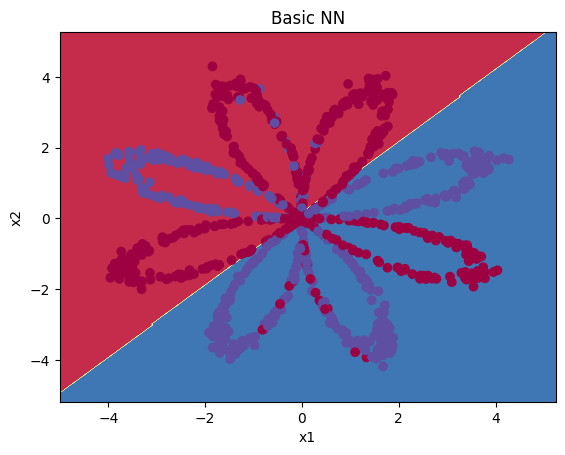

In [ ]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("Basic NN"); # ploteamos la curva de decision de nuestro modelo simple de NN

Encontramos un modelo bastante simple que nos clasifica los punts como si fuera una regresión logistica. Para mejorarlo debemos añadirle complejidad, y para ello, añadiremos más capas a nuestro modelo.

### Red neuronal con una capa oculta

* Una entrada con 2 características (`input_shape`)
* Una capa densa oculta, con 3 neuronas y función de activación sigmoide.
* Una salida (con función de activación sigmoide)

Podemos crear las capas de forma incremental con el método `add()`:

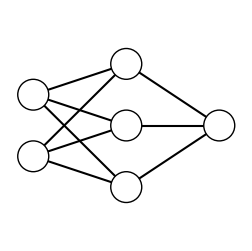

In [ ]:
draw_neural_net(.1,.9,.1,.9,[2,3,1]) # Simplemente ilustra el tipo de red

In [ ]:
model = keras.Sequential()
# capa oculta de 3 neuronas y activation =sigmoid
# La primera capa necesita tener el input_shape
model.add(layers.Dense(3, input_shape=(2,), activation='sigmoid'))

# capa output
model.add(layers.Dense(1,activation='sigmoid'))

# model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

Podemos tabíen definir el modelo con una lista d capas

In [ ]:
model = keras.Sequential([
    keras.Input(shape=(2, )),
    layers.Dense(3, activation='sigmoid', name='layer1'),
    layers.Dense(1, activation='sigmoid', name='layer3')
])

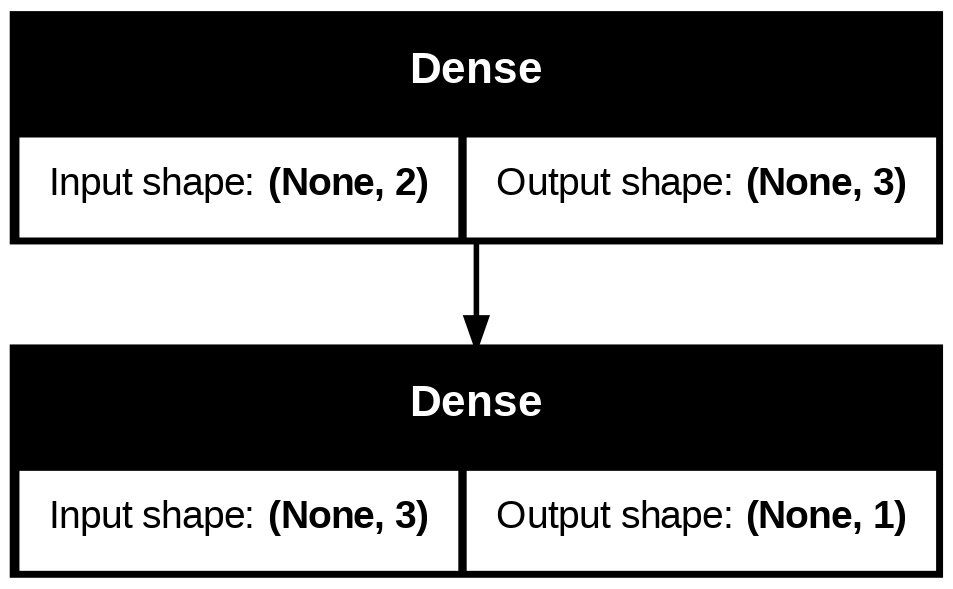

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
## Compilación y entrenamiento
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5280 - loss: 0.7105 - val_accuracy: 0.5437 - val_loss: 0.7020
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5650 - loss: 0.6971 - val_accuracy: 0.4412 - val_loss: 0.6929
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4968 - loss: 0.6884 - val_accuracy: 0.5688 - val_loss: 0.6859
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6140 - loss: 0.6811 - val_accuracy: 0.6475 - val_loss: 0.6796
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6785 - loss: 0.6742 - val_accuracy: 0.6575 - val_loss: 0.6736
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6787 - loss: 0.6676 - val_accuracy: 0.6612 - val_loss: 0.6679
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6800 - loss: 0.6614 - val_accuracy: 0.6612 - val_loss: 0.6626
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6788 - loss: 0.6556 - val_accuracy: 0.

In [ ]:
# Resultados
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.583666205406189
Test Accuracy: 0.6710000038146973


1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


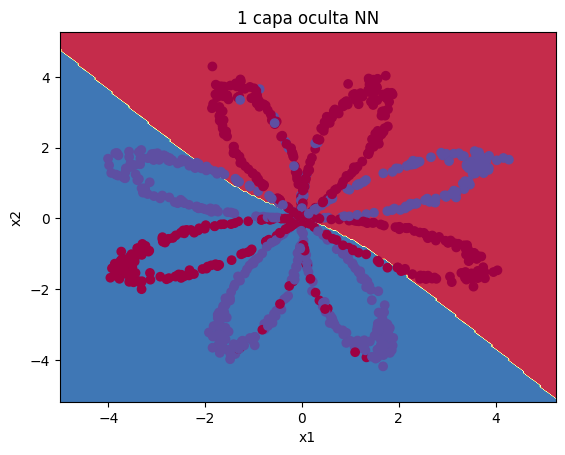

In [ ]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 capa oculta NN"); # representación gráfica

### Pregunta 1: Que passa si cambiamos la activation function para la primera capa oculta a `linear`?

In [ ]:
model = keras.Sequential()
# capa oculta de 3 neuronas
# La primera capa necesita tener el input_shape
model.add(layers.Dense(3, input_shape=(2,), activation='linear'))

# capa output
model.add(layers.Dense(1,activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compilación y entreno
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6515 - loss: 0.8162 - val_accuracy: 0.7225 - val_loss: 0.7024
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6544 - loss: 0.6989 - val_accuracy: 0.5938 - val_loss: 0.6644
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5265 - loss: 0.6642 - val_accuracy: 0.4988 - val_loss: 0.6626
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4682 - loss: 0.6600 - val_accuracy: 0.4975 - val_loss: 0.6635
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4728 - loss: 0.6597 - val_accuracy: 0.4988 - val_loss: 0.6637
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4744 - loss: 0.6596 - val_accuracy: 0.4988 - val_loss: 0.6637
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4744 - loss: 0.6596 - val_accuracy: 0.4988 - val_loss: 0.6637
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4744 - loss: 0.6596 - val_accuracy: 0.

In [ ]:
# Resultados
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.6507880687713623
Test Accuracy: 0.5139999985694885


1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step


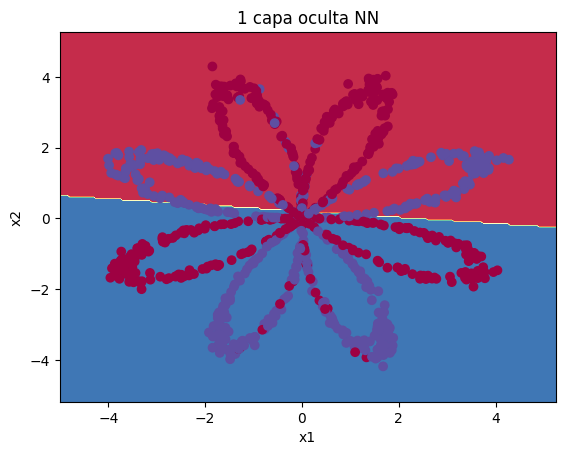

In [ ]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 capa oculta NN"); # representación gráfica

Al usar `linear` como activation en vez de `sgimoide` en la capa oculta, baja el rendimiento de nuestro modelo y vuelve a realizar una predicción lineal.

### Pregunta 2: Que pasa si añadimos mas neuronas a la primera capa oculta

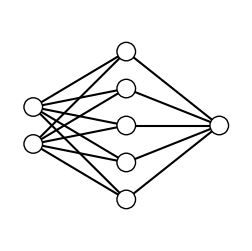

In [ ]:
draw_neural_net(.1,.9,.1,.9,[2,5,1])

In [ ]:
model = keras.Sequential()
# capa oculta de 3 neuronas
# La primera capa necesita tener el input_shape
model.add(layers.Dense(20, input_shape=(2,), activation='sigmoid'))

# capa output
model.add(layers.Dense(1,activation='sigmoid'))

In [ ]:
# Compilación y entreno
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4729 - loss: 0.7987 - val_accuracy: 0.5675 - val_loss: 0.6997
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6075 - loss: 0.6791 - val_accuracy: 0.6325 - val_loss: 0.6718
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6160 - loss: 0.6603 - val_accuracy: 0.5875 - val_loss: 0.6639
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5940 - loss: 0.6547 - val_accuracy: 0.5738 - val_loss: 0.6582
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5824 - loss: 0.6503 - val_accuracy: 0.5562 - val_loss: 0.6529
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5753 - loss: 0.6456 - val_accuracy: 0.5537 - val_loss: 0.6472
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5735 - loss: 0.6405 - val_accuracy: 0.5512 - val_loss: 0.6411
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5749 - loss: 0.6348 - val_accuracy: 0.

In [ ]:
# Resultados
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.4417230188846588
Test Accuracy: 0.875


1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


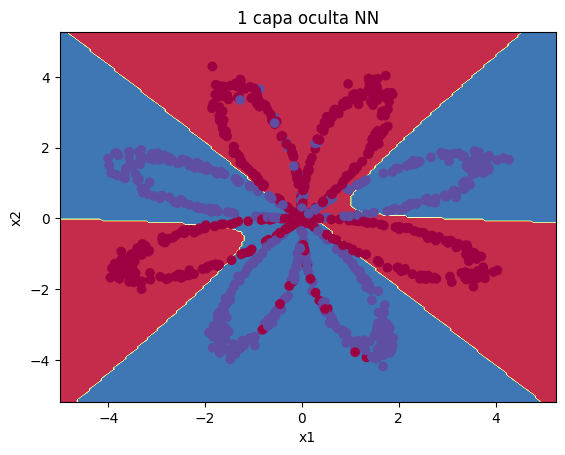

In [ ]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 capa oculta NN"); # representación gráfica

### Pregunta 3: Que pasa si le añadimos otra capa oculta?

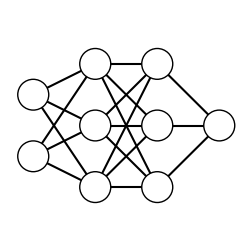

In [ ]:
draw_neural_net(.1,.9,.1,.9,[2,3,3,1])

In [ ]:
model = keras.Sequential()
# capa oculta de 3 neuronas
model.add(layers.Dense(20, input_shape=(2,), activation='sigmoid'))

# Segunda capa oculta de 3 neuronas
model.add(layers.Dense(12, activation='sigmoid'))

# capa output
model.add(layers.Dense(1,activation='sigmoid'))

In [ ]:
# Compilación y entreno
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4811 - loss: 0.9560 - val_accuracy: 0.4837 - val_loss: 0.7341
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4828 - loss: 0.7178 - val_accuracy: 0.5788 - val_loss: 0.6867
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5559 - loss: 0.6834 - val_accuracy: 0.5412 - val_loss: 0.6778
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5219 - loss: 0.6746 - val_accuracy: 0.5263 - val_loss: 0.6726
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5257 - loss: 0.6688 - val_accuracy: 0.5275 - val_loss: 0.6678
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5368 - loss: 0.6634 - val_accuracy: 0.5400 - val_loss: 0.6626
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5582 - loss: 0.6577 - val_accuracy: 0.5587 - val_loss: 0.6569
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5719 - loss: 0.6516 - val_accuracy: 0.

In [ ]:
# Resultados
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.4692286252975464
Test Accuracy: 0.8539999723434448


1352/1352 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


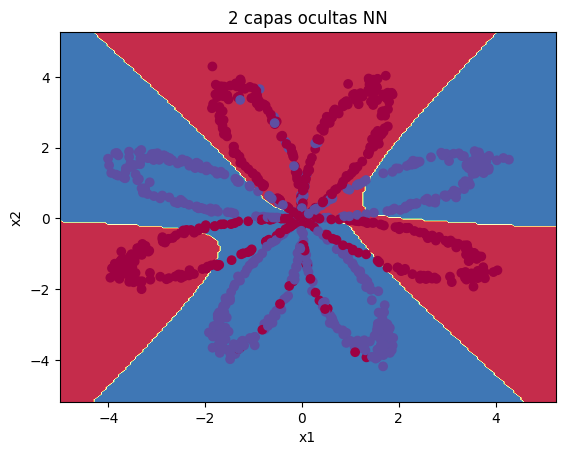

In [ ]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("2 capas ocultas NN"); # representación gráfica

Usamos la función de activación hiperbólica `tanh` con el primer modelo y la comparamos con la activation `sigmoid`

In [ ]:
model = keras.Sequential()
# capa oculta de 3 neuronas y activation =tanh
model.add(layers.Dense(3, input_shape=(2,), activation='tanh'))

# capa output
model.add(layers.Dense(1,activation='sigmoid'))

In [ ]:
# Compilación y entreno
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4861 - loss: 0.7345 - val_accuracy: 0.5550 - val_loss: 0.6864
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5559 - loss: 0.6789 - val_accuracy: 0.6900 - val_loss: 0.6466
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5950 - loss: 0.6432 - val_accuracy: 0.5450 - val_loss: 0.6249
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5157 - loss: 0.6245 - val_accuracy: 0.5300 - val_loss: 0.6137
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5015 - loss: 0.6145 - val_accuracy: 0.5225 - val_loss: 0.6062
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4945 - loss: 0.6078 - val_accuracy: 0.5225 - val_loss: 0.6003
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4977 - loss: 0.6026 - val_accuracy: 0.5225 - val_loss: 0.5953
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5009 - loss: 0.5982 - val_accuracy: 0.

In [ ]:
# Resultados
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.5451213717460632
Test Accuracy: 0.6050000190734863


1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1s 970us/step


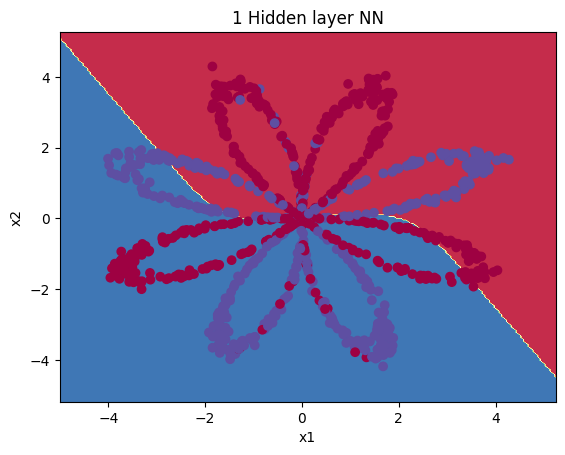

In [ ]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN"); # representación gráfica

### Practica 1

Vamos a repetir el proceso con un dataset distinto

In [ ]:
N = 5000
X, y = sklearn.datasets.make_moons(n_samples=N, noise = 0.18)

In [ ]:
X.shape

(5000, 2)

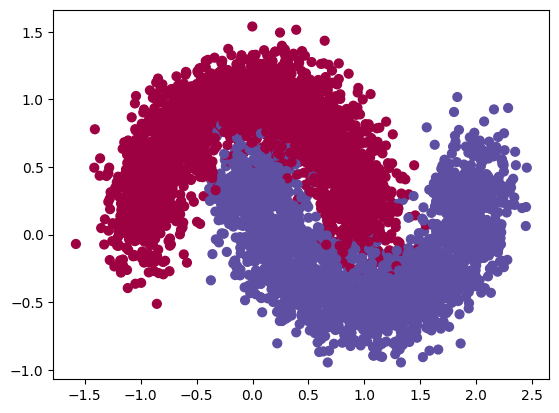

In [ ]:
# Visualización de los datos:

plt.scatter(X[:,0],X[:,1], c=y.ravel(),s=40, cmap=plt.cm.Spectral);

In [ ]:
# Train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(X , y, test_size=0.2
)

print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))


X shape:(5000, 2), y shape:(5000,)
X_train shape:(4000, 2), y_train shape:(4000,)
X_test shape:(1000, 2), y_test shape:(1000,)


#### Definición del modelo

In [ ]:
model = keras.Sequential()
# capa oculta de 3 neuronas
model.add(layers.Dense(20, input_shape=(2,), activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(20, activation='relu'))

# capa output
model.add(layers.Dense(1,activation='sigmoid'))

In [ ]:
# Compilación y entrenamiento
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=32)

Epoch 1/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6498 - loss: 0.6762 - val_accuracy: 0.8562 - val_loss: 0.3968
Epoch 2/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8483 - loss: 0.3660 - val_accuracy: 0.8775 - val_loss: 0.2848
Epoch 3/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8653 - loss: 0.2993 - val_accuracy: 0.8913 - val_loss: 0.2559
Epoch 4/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8772 - loss: 0.2711 - val_accuracy: 0.9038 - val_loss: 0.2316
Epoch 5/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8914 - loss: 0.2445 - val_accuracy: 0.9175 - val_loss: 0.2061
Epoch 6/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9075 - loss: 0.2147 - val_accuracy: 0.9337 - val_loss: 0.1778
Epoch 7/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9266 - loss: 0.1814 - val_accuracy: 0.9475 - val_loss: 0.1488
Epoch 8/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9498 - loss: 0.1467 - val_accuracy: 0.

In [ ]:
# Resultados
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.056219786405563354
Test Accuracy: 0.9789999723434448


329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


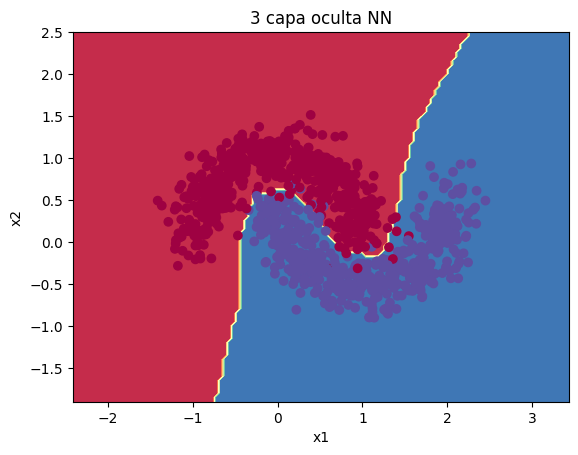

In [ ]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("3 capa oculta NN"); # representación gráfica

### Guardar y cargar Moldeos eras

Es posible guardar los modelos enteros en una simple call usando los formatos `.keras` o `.h5.`.

* `.keras` : El formato recomendable de TensrFlow
* `.h5.`: Un formato mas antiguo

In [ ]:
import datetime

# Guardar el modelo con timestamp
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_name_keras= f"keras_model_{current_time}.keras"
model_name_h5= f"keras_model_{current_time}.h5"

# Guardar en formato .keras
model.save(model_name_keras)

# Guardar en formato .h5
model.save(model_name_h5)

print(f"Models saved as:{model_name_keras} and {model_name_h5}" )

Models saved as:keras_model_20251016-164146.keras and keras_model_20251016-164146.h5


In [ ]:
# lista de documentos en el directorio
!ls -l

total 244
-rw-r--r-- 1 root root 47936 Oct 16 16:38 keras_model_20251016-163804.h5
-rw-r--r-- 1 root root 41338 Oct 16 16:38 keras_model_20251016-163804.keras
-rw-r--r-- 1 root root 47936 Oct 16 16:41 keras_model_20251016-164146.h5
-rw-r--r-- 1 root root 41340 Oct 16 16:41 keras_model_20251016-164146.keras
-rw-r--r-- 1 root root 21874 Oct 16 16:40 Modelito_19.keras
-rw-r--r-- 1 root root 30749 Oct 16 16:40 model.png
drwxr-xr-x 1 root root  4096 Oct 15 13:42 sample_data


In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo previo
loaded_model = load_model(model_name_keras)

# Evaluación del modelo cargado
loss, accuracy = loaded_model.evaluate(X_test,y_test)
print(f"Loaded model accuracy: {accuracy*100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9798 - loss: 0.0503
Loaded model accuracy: 97.90%


### Pregunta 4: Entrena 10 epochs, guarda el model, cargarlo, y luego entrena 10 epochs mas.

In [ ]:
model = keras.Sequential()
# capa oculta de 3 neuronas
model.add(layers.Dense(20, input_shape=(2,), activation='relu'))

# capa output
model.add(layers.Dense(1,activation='sigmoid'))

In [ ]:
# Compilación y entrenamiento
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7559 - loss: 0.5521 - val_accuracy: 0.7987 - val_loss: 0.4569
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8020 - loss: 0.4421 - val_accuracy: 0.8300 - val_loss: 0.3759
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8225 - loss: 0.3760 - val_accuracy: 0.8525 - val_loss: 0.3293
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8384 - loss: 0.3370 - val_accuracy: 0.8675 - val_loss: 0.2988
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8543 - loss: 0.3110 - val_accuracy: 0.8825 - val_loss: 0.2777
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8617 - loss: 0.2927 - val_accuracy: 0.8875 - val_loss: 0.2630
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8681 - loss: 0.2798 - val_accuracy: 0.8925 - val_loss: 0.2527
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8709 - loss: 0.2707 - val_accuracy: 0.

In [ ]:
# Resultados
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.2688177227973938
Test Accuracy: 0.8659999966621399


329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


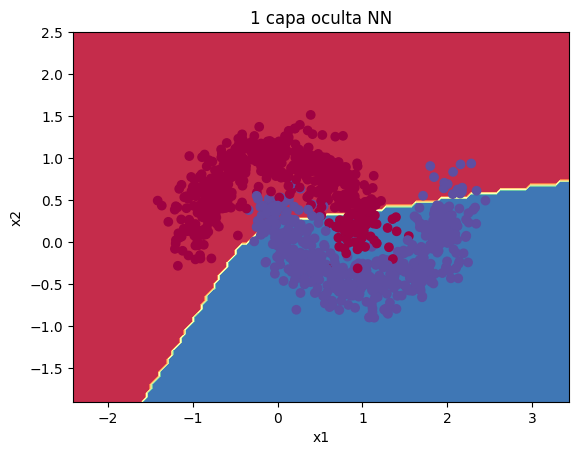

In [ ]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 capa oculta NN"); # representación gráfica

In [ ]:
# Guardar el modelo con timestamp
model_name = "Modelito_19.keras"

# Guardar en formato .keras
model.save(model_name)

print(f"Models saved as:{model_name}" )

Models saved as:Modelito_19.keras


In [ ]:
# Cargar el modelo previo
loaded_model = load_model(model_name)

In [ ]:
model.fit(X_train,y_train, epochs=20, validation_split=0.2, batch_size=64)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8768 - loss: 0.2562 - val_accuracy: 0.9050 - val_loss: 0.2342
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8769 - loss: 0.2543 - val_accuracy: 0.9062 - val_loss: 0.2328
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8768 - loss: 0.2528 - val_accuracy: 0.9062 - val_loss: 0.2314
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8774 - loss: 0.2515 - val_accuracy: 0.9062 - val_loss: 0.2303
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8780 - loss: 0.2503 - val_accuracy: 0.9062 - val_loss: 0.2292
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8784 - loss: 0.2492 - val_accuracy: 0.9075 - val_loss: 0.2282
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8788 - loss: 0.2482 - val_accuracy: 0.9075 - val_loss: 0.2273
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8801 - loss: 0.2473 - val_accuracy: 0.9087 - val_loss:

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.2581002414226532
Test Accuracy: 0.8830000162124634


329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


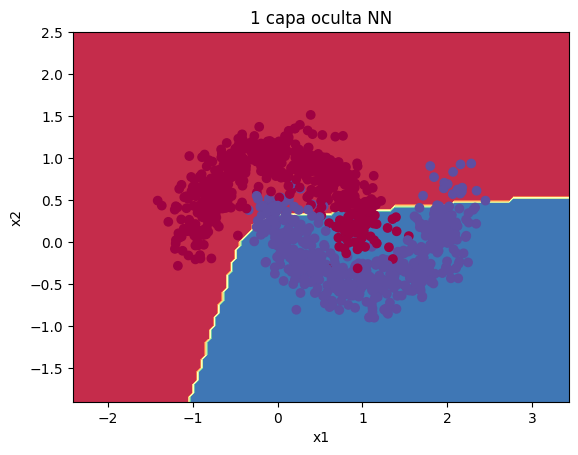

In [ ]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 capa oculta NN"); # representación gráfica

### APIs funcionales

La API funcional de Keras permite definir la topología de los modelos como un grafo dirigido acíclico de las capas. A continuación, construiremos el mismo modelo que en la sección anterior, pero usando la API Funcional de Keras.

Primero debes comenzar con una entrada de datos:

```python
inputs = keras.input(shape=(8,))
```

Definimos las capas que incluiremos en la red y las relaciones entre ellas. Es importante notar que cada línea detalla el tipo de cada y sus propiedades (número de neuronas, función de activación, nombre,etc.) y, justo al final, entre paréntesis, se coloca el nombre de la variable en la que hemos guardado la capa cuya salida se conectará a la entrada de la capa que estamos declarando.

```python
layer_1 = layers.Dense(4, activation='sigmoid', name='layer_1')(inputs)

layer_2 = layers.Dense(4, activation='sigmoid', name='layer_2')(layer_1)
```

La acción de "llamar" a la capa `dense()(inuts)` es como dibujar una flecha desde `inputs` hacia la capa que acabas de crear, Estas "pasando" los datos de entrada a la capa densa, y obtienes `layer_1` como salida.

Finalmente, definimos las salidas de la red:

```python
outputs = layers.Dense(1,name='output_layer')(layer_2)
```

Creamos el modelo especificando las entradas y salidas:

```python
model = keras.model(inputs =inputs, outputs=outputs)



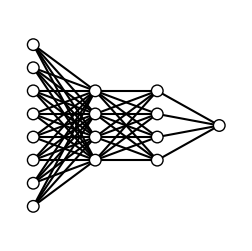

In [ ]:
draw_neural_net(.1, .9, .1,.9, [8,4,4,1])

In [ ]:
inputs = keras.Input(shape=(8,))
layer_1 = layers.Dense(4, activation='sigmoid', name='layer_1')(inputs)
layer_2 = layers.Dense(4, activation='sigmoid', name='layer_2')(layer_1)
outputs = layers.Dense(1,name='output_layer')(layer_2)
model = keras.Model(inputs =inputs, outputs=outputs)

model.summary()

Model: "functional_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61 (244.00 B)

 Trainable params: 61 (244.00 B)

 Non-trainable params: 0 (0.00 B)

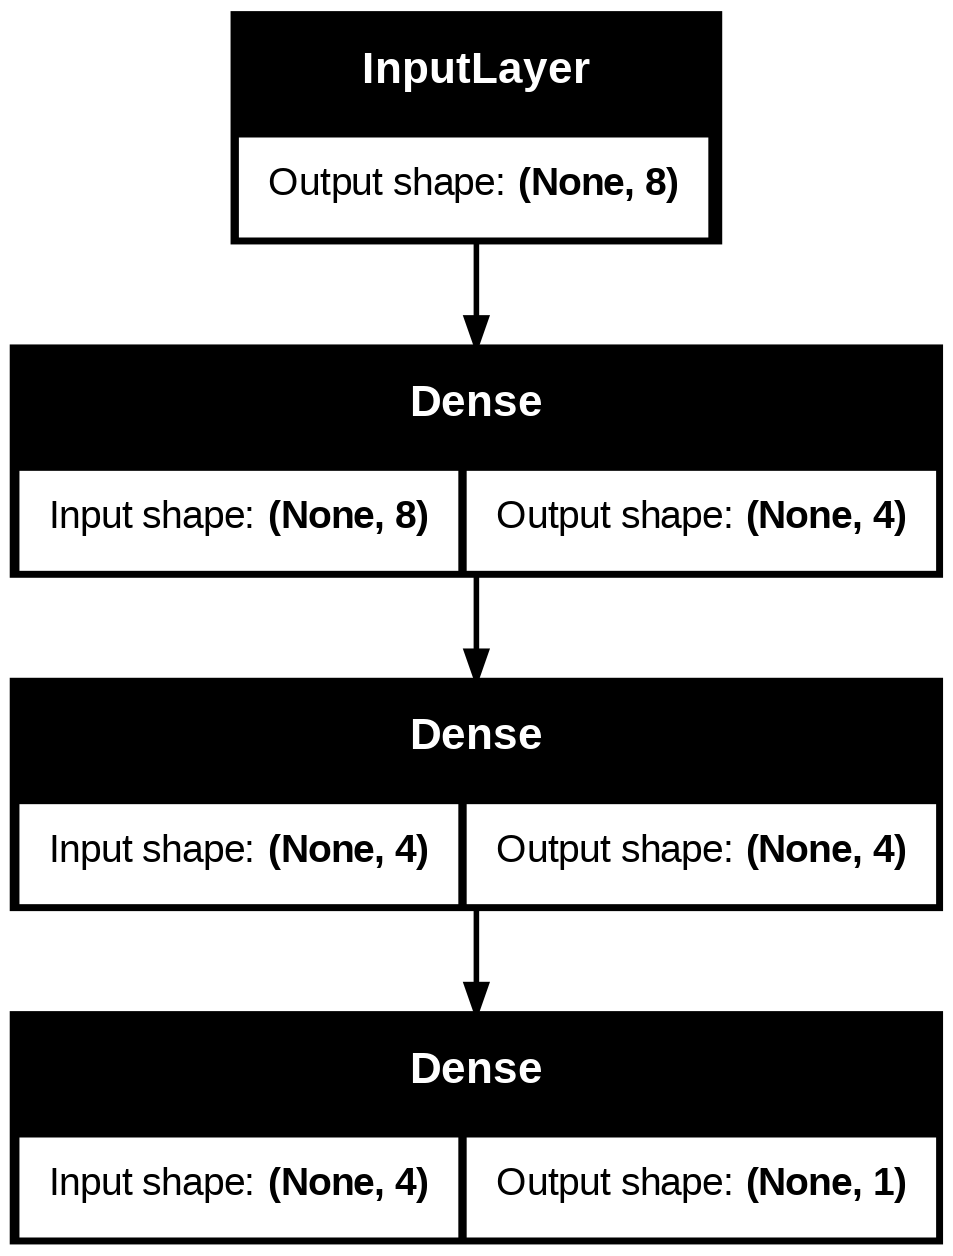

In [ ]:
plot_model(model,show_shapes=True)

### Practica II

Repitamos el proceso con otro dataset


In [ ]:
N = 5000
X, y = sklearn.datasets.make_circles(n_samples=N, factor=.65, noise=0.065)

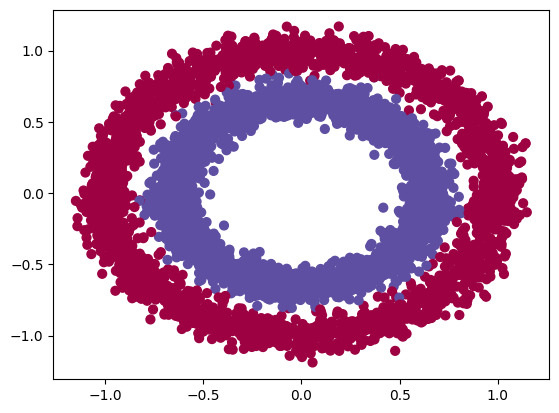

In [ ]:
# Visualizamos los datos
plt.scatter(X[:,0],X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral)

In [ ]:
# Train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(X , y, test_size=0.2
)

print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(4000, 2), y_train shape:(4000,)
X_test shape:(1000, 2), y_test shape:(1000,)


In [ ]:
model = keras.Sequential()
# capa oculta de 4 neuronas
model.add(layers.Dense(4, input_shape=(2,), activation='relu'))
model.add(layers.Dense(4, activation='relu'))

# capa output
model.add(layers.Dense(1,activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compilación y entrenamiento
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=32)

Epoch 1/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5003 - loss: 0.7051 - val_accuracy: 0.4550 - val_loss: 0.6966
Epoch 2/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4869 - loss: 0.6900 - val_accuracy: 0.4900 - val_loss: 0.6892
Epoch 3/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5133 - loss: 0.6824 - val_accuracy: 0.5188 - val_loss: 0.6823
Epoch 4/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5281 - loss: 0.6756 - val_accuracy: 0.5325 - val_loss: 0.6754
Epoch 5/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5418 - loss: 0.6690 - val_accuracy: 0.5663 - val_loss: 0.6686
Epoch 6/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5795 - loss: 0.6624 - val_accuracy: 0.5663 - val_loss: 0.6611
Epoch 7/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5788 - loss: 0.6549 - val_accuracy: 0.5750 - val_loss: 0.6518
Epoch 8/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5921 - loss: 0.6451 - val_accuracy: 0.

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.19042672216892242
Test Accuracy: 0.9300000071525574


229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


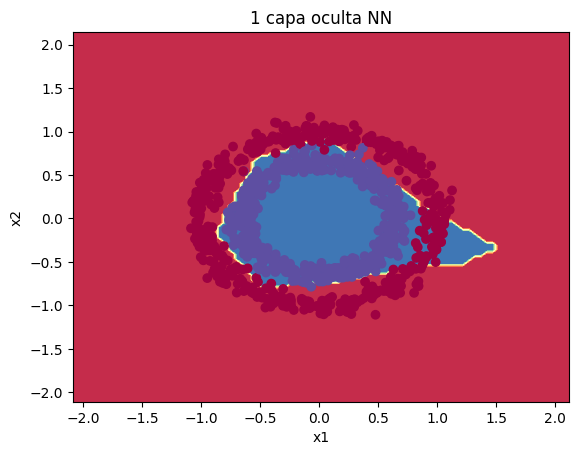

In [ ]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 capa oculta NN"); # representación gráfica